In [1]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
import copy
import pickle
import xarray as xr
import pickle
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua4 as eua
import trajectory as trj

import h5py
import ray
import pyproj
# ray.init(num_cpus=7)


In [2]:

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

In [106]:
def get_cuon(stat, year_s, year_e):
    # stat = '11035'
    # year = '2000'
    dt_from = datetime_to_seconds(np.datetime64(str(year_s)+'-01-01'))
    dt_to = datetime_to_seconds(np.datetime64(str(year_e)+'-12-31'))

    conv_file = glob.glob('/mnt/users/scratch/leo/scratch/converted_v9/newindex/*' + stat + '*_CEUAS_merged_v1.nc')[0]
    # conv_file = glob.glob('./0-20001-0-11035_CEUAS_merged_v1.nc')[0]

    df_dict = {}
    u_df_dict = {}
    v_df_dict = {}

    stdplevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500]


    with h5py.File(conv_file, 'r') as file:
        rts = file['recordindices']['recordtimestamp'][:]
        idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
        if len(idx) == 0:
            print('(1) NO DATA FOUND IN CONVERTED_V9: ', sid)
        u_idx = file['recordindices']['139'][idx]
        v_idx = file['recordindices']['140'][idx]
        t_idx = file['recordindices']['126'][idx]
        
#         plevs = [1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000,92500,100000]
        
#         mask = file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]]
#         mask = np.isin(mask,plevs)

#         u_mask = file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]]
#         u_mask = np.isin(u_mask,plevs)

#         v_mask = file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]]
#         v_mask = np.isin(v_mask,plevs)
        mask = len(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]])*[True]
        u_mask = len(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]])*[True]
        v_mask = len(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]])*[True]

        # t_len = len(mask[mask == True])
        # u_len = len(u_mask[u_mask == True])
        # v_len = len(v_mask[v_mask == True])
        
        t_len = len(mask)
        u_len = len(u_mask)
        v_len = len(v_mask)

        df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['date_time'] = list(file['observations_table']['date_time'][t_idx[0]:t_idx[-1]][mask])
        df_dict['observation_value'] = list(file['observations_table']['observation_value'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude'] = list(file['observations_table']['latitude'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude'] = list(file['observations_table']['longitude'][t_idx[0]:t_idx[-1]][mask])
        repid = np.asarray(file['observations_table']['report_id'][t_idx[0]:t_idx[-1]][mask])
        df_dict['report_id'] = list(repid.view('|S{}'.format(repid.shape[1])).flatten().astype(str))

        df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
        df_dict['fg_depar'] = list(file['era5fb']['fg_depar@body'][t_idx[0]:t_idx[-1]][mask])
        df_dict['an_depar'] = list(file['era5fb']['an_depar@body'][t_idx[0]:t_idx[-1]][mask])
        df_dict['biascorr'] = list(file['era5fb']['biascorr@body'][t_idx[0]:t_idx[-1]][mask])
        df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
        df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])

        u_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['date_time'] = list(file['observations_table']['date_time'][u_idx[0]:u_idx[-1]][u_mask])
        u_df_dict['observation_value'] = list(file['observations_table']['observation_value'][u_idx[0]:u_idx[-1]][u_mask])

        v_df_dict['z_coordinate'] = list(file['observations_table']['z_coordinate'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['date_time'] = list(file['observations_table']['date_time'][v_idx[0]:v_idx[-1]][v_mask])
        v_df_dict['observation_value'] = list(file['observations_table']['observation_value'][v_idx[0]:v_idx[-1]][v_mask])


        # df_dict['observation_value'] = ['air_temperature']*t_len
        # u_df_dict['observation_value'] = ['eastward_wind']*u_len
        # v_df_dict['observation_value'] = ['northward_wind']*v_len

        df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
        df = pd.DataFrame.from_dict(df_dict)
        df = df.rename(columns={'observation_value':'air_temperature'})

        u_df_dict['date_time'] = seconds_to_datetime(u_df_dict['date_time'])
        u_df = pd.DataFrame.from_dict(u_df_dict)
        u_df = u_df.rename(columns={'observation_value':'eastward_wind_speed'})

        v_df_dict['date_time'] = seconds_to_datetime(v_df_dict['date_time'])
        v_df = pd.DataFrame.from_dict(v_df_dict)
        v_df = v_df.rename(columns={'observation_value':'northward_wind_speed'})

        # put dfs together:
        df = df.merge(u_df, how='inner', on=['date_time','z_coordinate'])
        df = df.merge(v_df, how='inner', on=['date_time','z_coordinate'])
    #         print(df)
    return df

In [127]:
df = get_cuon('94120', '1980', '1993')

In [130]:
df = get_cuon('70219', '1990', '2000')

In [131]:
df = df[df.z_coordinate == 5000]
df = df[np.logical_and(df.air_temperature > 190, df.air_temperature < 225)]

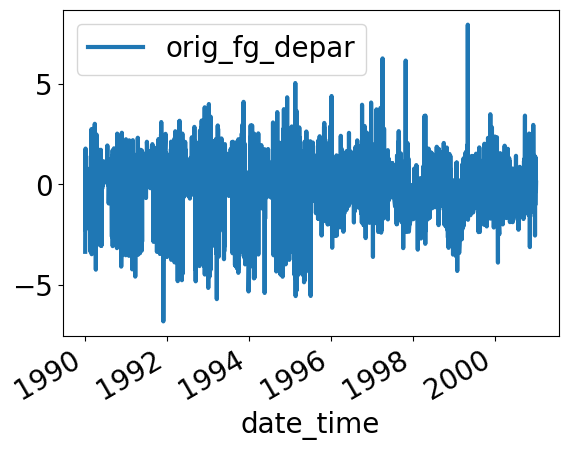

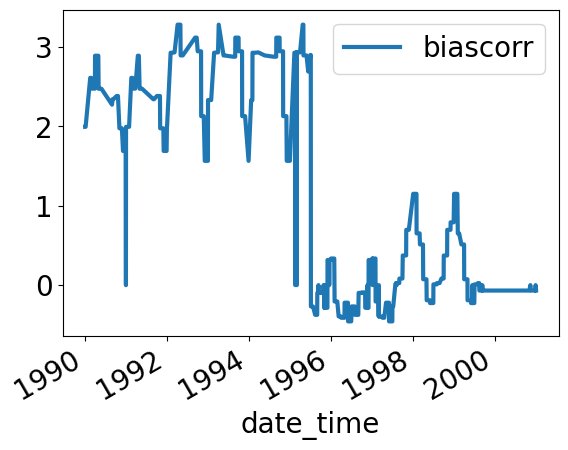

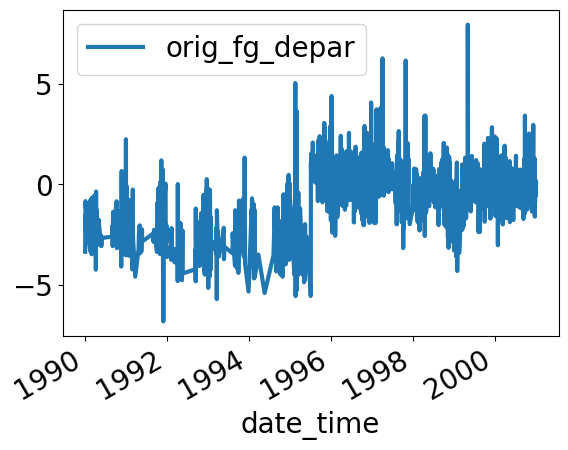

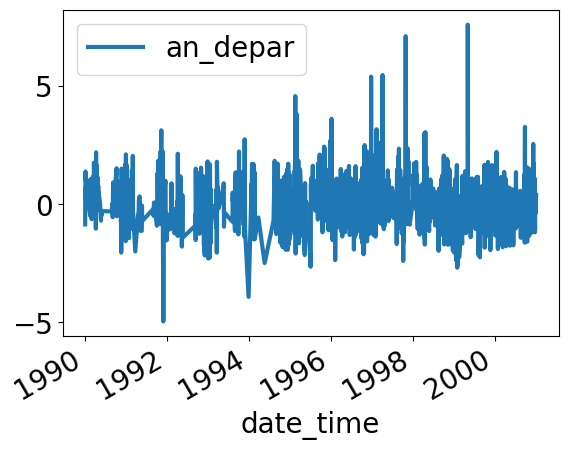

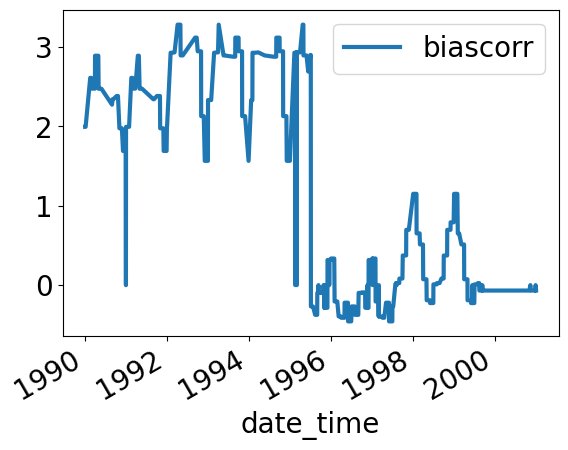

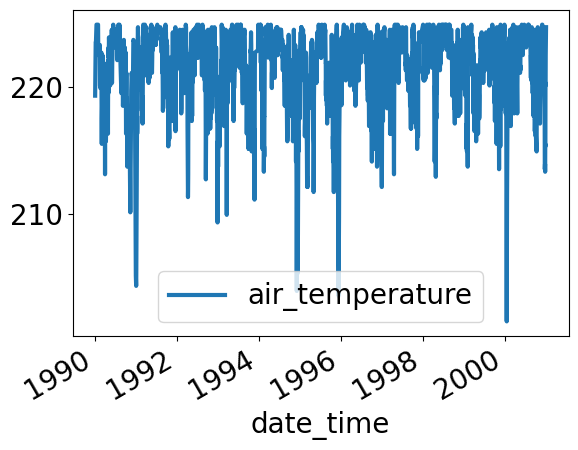

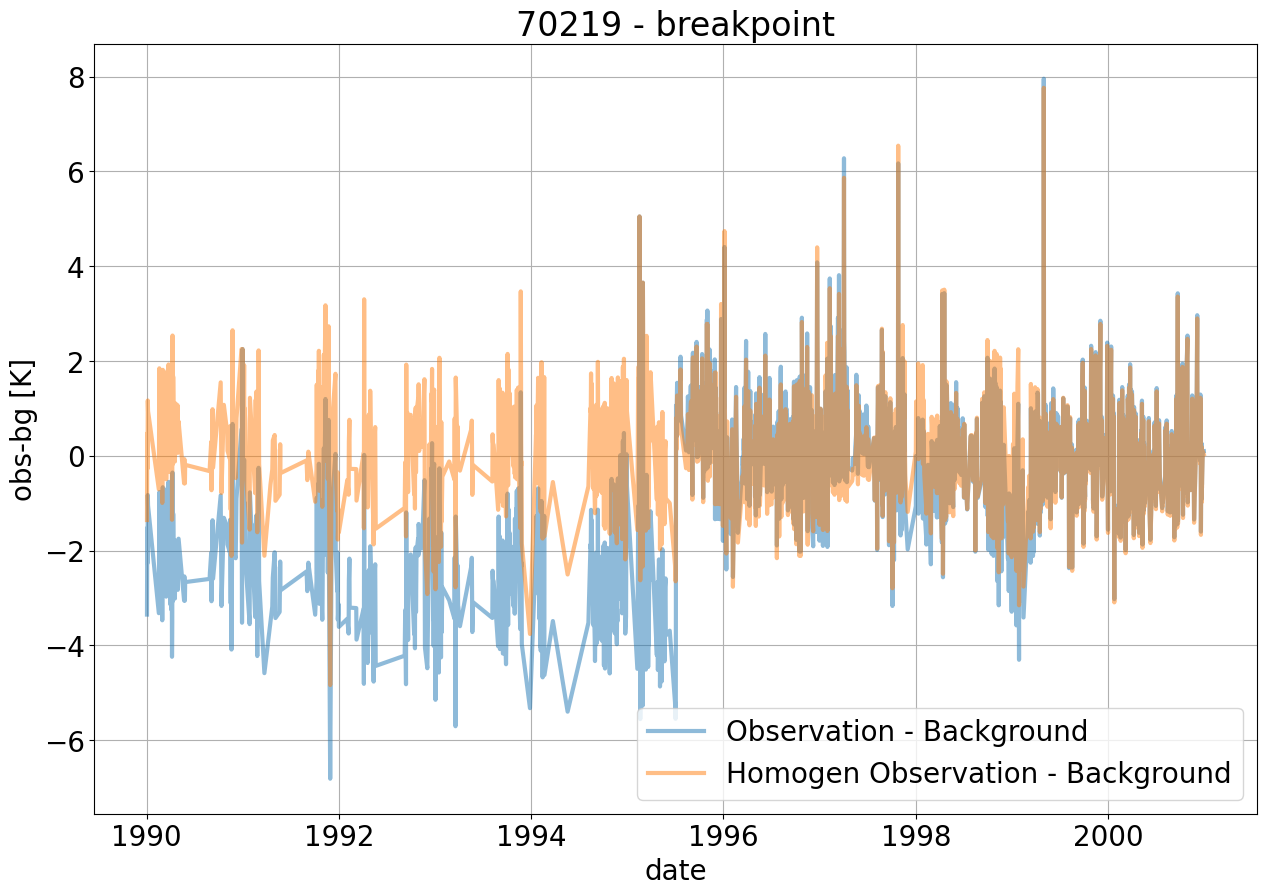

In [141]:
df['orig_fg_depar'] = df['fg_depar'] - df['biascorr']
df.plot(x='date_time', y='orig_fg_depar')
df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].plot(x='date_time', y='biascorr')
df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].plot(x='date_time', y='orig_fg_depar')
df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].plot(x='date_time', y='an_depar')
df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].plot(x='date_time', y='biascorr')

df[np.logical_and(df.date_time.dt.hour > 6, df.date_time.dt.hour <= 18)].plot(x='date_time', y='air_temperature')

fig, ax = maplt.subplots(1, 1, figsize = (15,10))
#     fig, ax1 = maplt.subplots(1, 1, figsize = (15,10))
ax.plot(df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].date_time,df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].orig_fg_depar, alpha = 0.5, label='Observation - Background')
ax.plot(df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].date_time,df[np.logical_or(df.date_time.dt.hour > 18, df.date_time.dt.hour <= 6)].fg_depar,alpha = 0.5, label='Homogen Observation - Background')

# ax.plot(np.array(diffs),stdplevs,color='orange', label='Difference')
# ax.plot(np.array(dbase),stdplevs, color='blue', label='Undisplaced')
# ax.plot(np.array(ddisp),stdplevs, color='red', label='Displaced')
ax.set_title('70219 - breakpoint')
ax.legend(loc='upper right')
# ax.set_ylim(ax.get_ylim()[::-1])
ax.set_ylabel('obs-bg [K]')
ax.set_xlabel('date')
ax.legend(loc='lower right')
ax.grid()
maplt.show()
maplt.close()

In [121]:
df['orig_fg_depar'] - df['biascorr']

KeyError: 'orig_fg_depar'

In [83]:
night_df = df[df.date_time.dt.hour == 0]
day_df = df[df.date_time.dt.hour == 12]


<AxesSubplot:xlabel='date_time'>

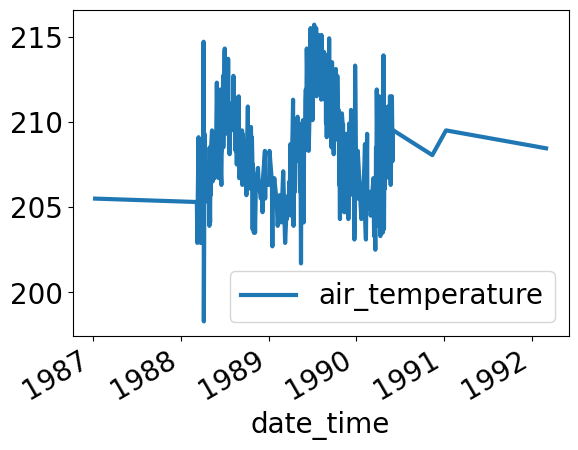

In [67]:
day_df[day_df.z_coordinate == 5000].plot(x='date_time', y='air_temperature')

<AxesSubplot:xlabel='date_time'>

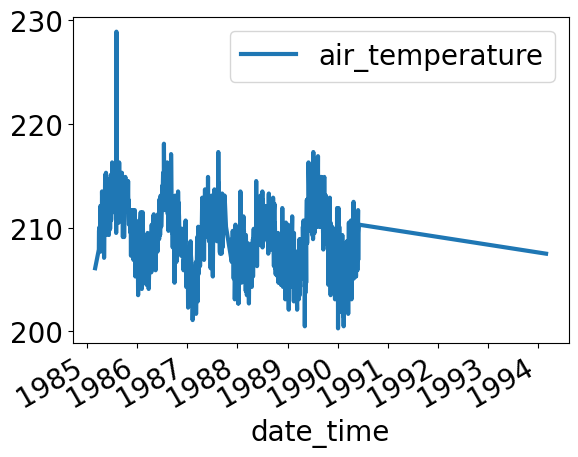

In [68]:
night_df[night_df.z_coordinate == 5000].plot(x='date_time', y='air_temperature')

In [33]:
day_df.air_temperature - night_df.air_temperature

105537   NaN
105549   NaN
105565   NaN
105580   NaN
105595   NaN
          ..
230785   NaN
230802   NaN
230829   NaN
230841   NaN
230865   NaN
Name: air_temperature, Length: 7303, dtype: float32

<AxesSubplot:xlabel='date_time'>

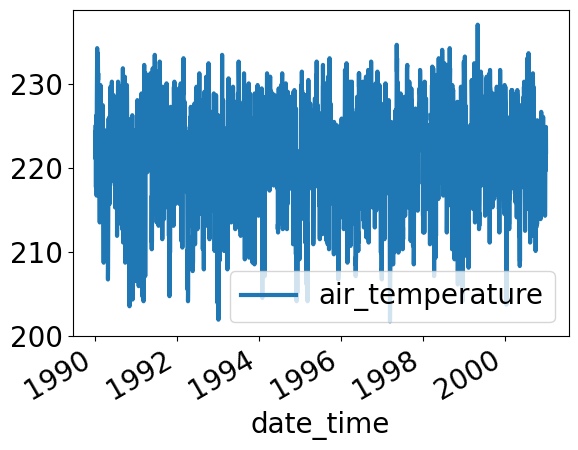

In [21]:
df[np.logical_and(np.logical_and(np.logical_and(df.z_coordinate == 20000, df.date_time < '2001'), df.date_time > '1990'), df.date_time.dt.hour == 12)].plot(x='date_time', y='air_temperature')

In [18]:
df[np.logical_and(np.logical_and(df.z_coordinate == 20000, df.date_time < '2001'), df.date_time > '1990')]

,z_coordinate,date_time,air_temperature,latitude,longitude,report_id,RASE_bias_estimate,latitude_displacement,longitude_displacement,time_since_launch,eastward_wind_speed,northward_wind_speed
105537,20000.0,1990-01-02 00:00:00,217.899994,60.779999,-161.800003,10000007944,0.848770,0.120817,-0.150904,2280.625719,6.929646,6.929646
105549,20000.0,1990-01-02 12:00:00,222.899994,60.779999,-161.800003,10000007945,-0.374250,0.086232,-0.124658,2239.990158,6.929646,6.929646
105565,20000.0,1990-01-03 00:00:00,225.500000,60.779999,-161.800003,10000007946,0.848770,0.206449,0.071266,2250.749983,1.788576,10.143519
105580,20000.0,1990-01-03 12:00:00,224.300003,60.779999,-161.800003,10000007947,-0.374250,0.161526,0.291166,2198.438883,9.786087,5.650000
105595,20000.0,1990-01-04 00:00:00,224.100006,60.779999,-161.800003,10000007948,0.848770,0.043686,0.411372,2247.829830,10.738715,6.200000
...,...,...,...,...,...,...,...,...,...,...,...,...
230785,20000.0,2000-12-28 12:00:00,219.699997,60.779999,-161.800003,10000015748,NaN,0.197885,-0.678569,2222.836230,-3.420202,9.396926
230802,20000.0,2000-12-29 00:00:00,221.500000,60.779999,-161.800003,10000015749,-0.232812,0.102913,-0.687136,2206.949929,-6.500000,11.258330
230829,20000.0,2000-12-30 00:00:00,223.500000,60.779999,-161.800003,10000015751,NaN,0.323314,-0.673174,2204.156594,-4.446262,12.216004
230841,20000.0,2000-12-30 12:00:00,224.899994,60.779999,-161.800003,10000015752,-0.147849,0.180608,-0.204591,2195.471597,-7.607129,16.313540
